In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#ACEH

##Data Preparation

In [2]:
aceh = pd.read_csv("dataframe (w_o test).csv")
#pilih hanya kolom "Date" dan "Aceh"
aceh = aceh[["Date", "Aceh"]]

#ubah tipe data "Date"
aceh["Date"] = pd.to_datetime(aceh["Date"])

#jadikan kolom "Date" sebagai index
aceh = aceh.set_index("Date")
aceh.index

aceh.head()

,Aceh
Date,
2022-01-01,22360.0
2022-01-02,23340.0
2022-01-03,22050.0
2022-01-04,22460.0
2022-01-05,19630.0


In [3]:
#convert to time series:
ts = aceh['Aceh']
ts.head(10)

Date
2022-01-01    22360.0
2022-01-02    23340.0
2022-01-03    22050.0
2022-01-04    22460.0
2022-01-05    19630.0
2022-01-06    20140.0
2022-01-07    22960.0
2022-01-08    21730.0
2022-01-09    20430.0
2022-01-10    19570.0
Name: Aceh, dtype: float64

##Indexing TS Arrays

In [4]:
#Specific the index as a string constant
ts['2022-01-01']

22360.0

In [5]:
#Import the datetime library and use 'datetime' function
from datetime import datetime
ts[datetime(2022,1,1)]

22360.0

In [6]:
ts['2022']

Date
2022-01-01    22360.0
2022-01-02    23340.0
2022-01-03    22050.0
2022-01-04    22460.0
2022-01-05    19630.0
               ...   
2022-12-27    36260.0
2022-12-28    36100.0
2022-12-29    34730.0
2022-12-30    33980.0
2022-12-31    31350.0
Name: Aceh, Length: 365, dtype: float64

##Checking for Stationary

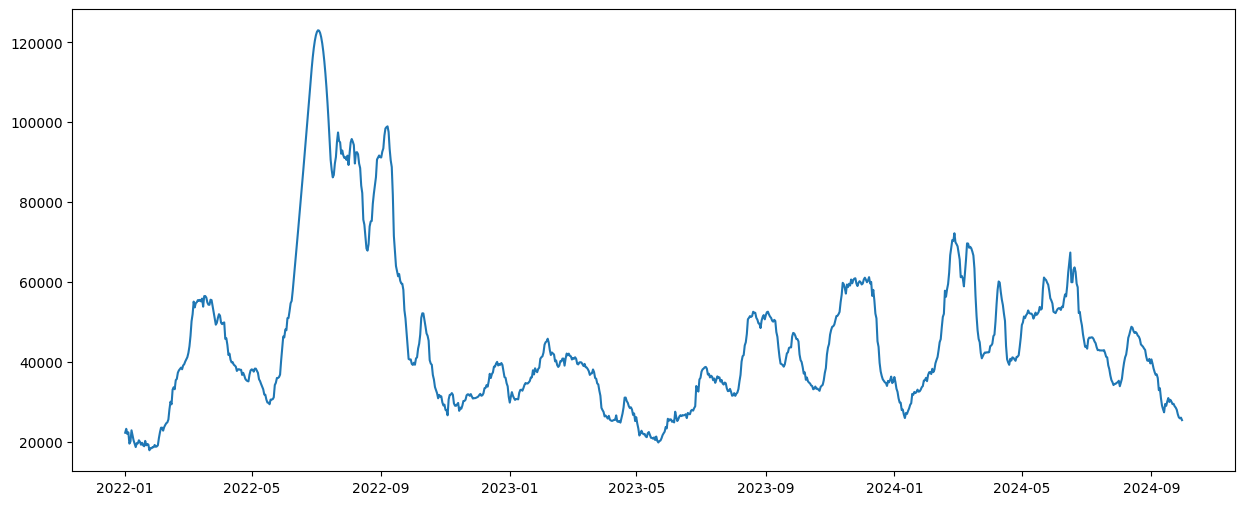

In [7]:
#plot the time series
plt.plot(ts)

In [8]:
#function for testing stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,window):

    #Determing rolling statistics
    #ts_log = np.log(ts)
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolmean = ts_log.rolling(window=12).mean()
    rolmean = pd.Series(timeseries).rolling(window=window).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    #rolstd = ts_log.rolling(window=12).std()
    rolstd = pd.Series(timeseries).rolling(window=window).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

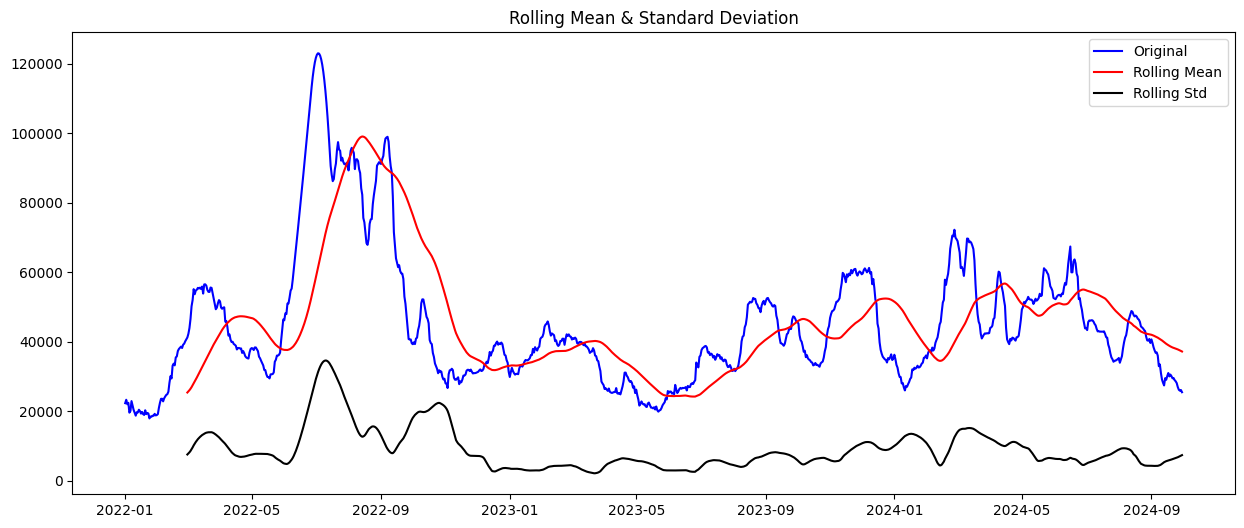

Results of Dickey-Fuller Test:
Test Statistic                  -3.376604
p-value                          0.011783
#Lags Used                      12.000000
Number of Observations Used    991.000000
Critical Value (1%)             -3.436966
Critical Value (5%)             -2.864461
Critical Value (10%)            -2.568325
dtype: float64


In [9]:
test_stationarity(ts,60)

##Making TS Stationary

###Estimating & Eliminating Trend


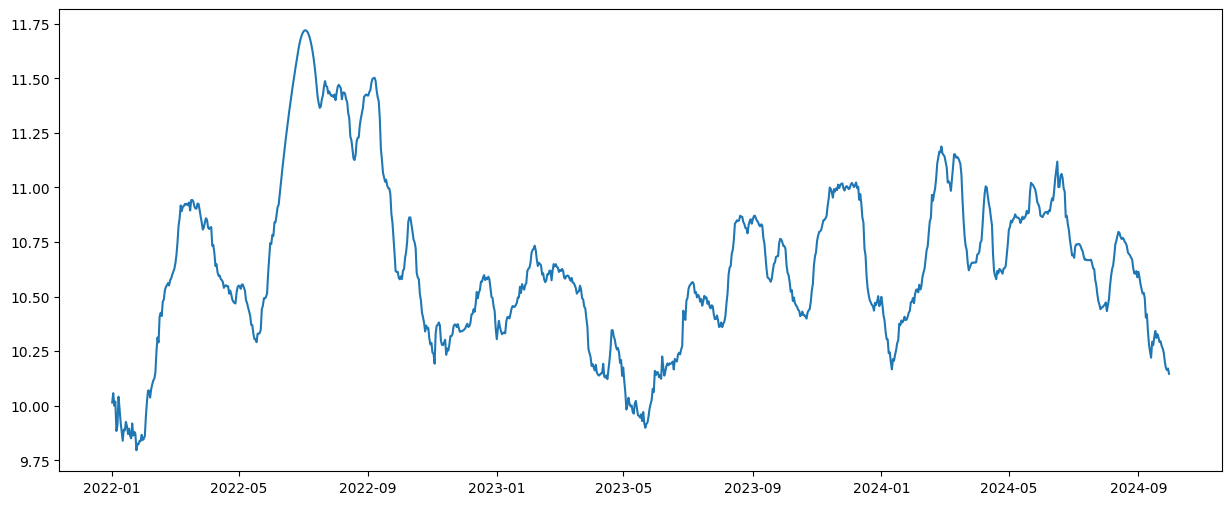

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

###Smoothing

####Moving Average

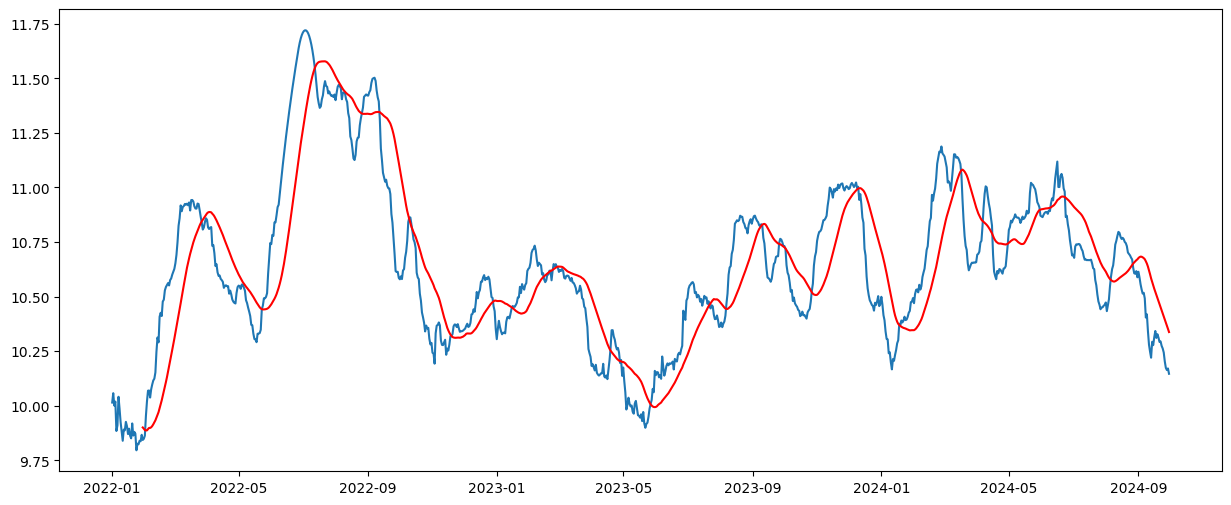

In [11]:
moving_avg = pd.Series(ts_log).rolling(window=30).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2022-01-01   NaN
2022-01-02   NaN
2022-01-03   NaN
2022-01-04   NaN
2022-01-05   NaN
2022-01-06   NaN
2022-01-07   NaN
2022-01-08   NaN
2022-01-09   NaN
2022-01-10   NaN
2022-01-11   NaN
2022-01-12   NaN
Name: Aceh, dtype: float64

In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Date
2022-01-30   -0.057254
2022-01-31   -0.046427
2022-02-01   -0.025781
2022-02-02    0.065857
2022-02-03    0.132549
Name: Aceh, dtype: float64

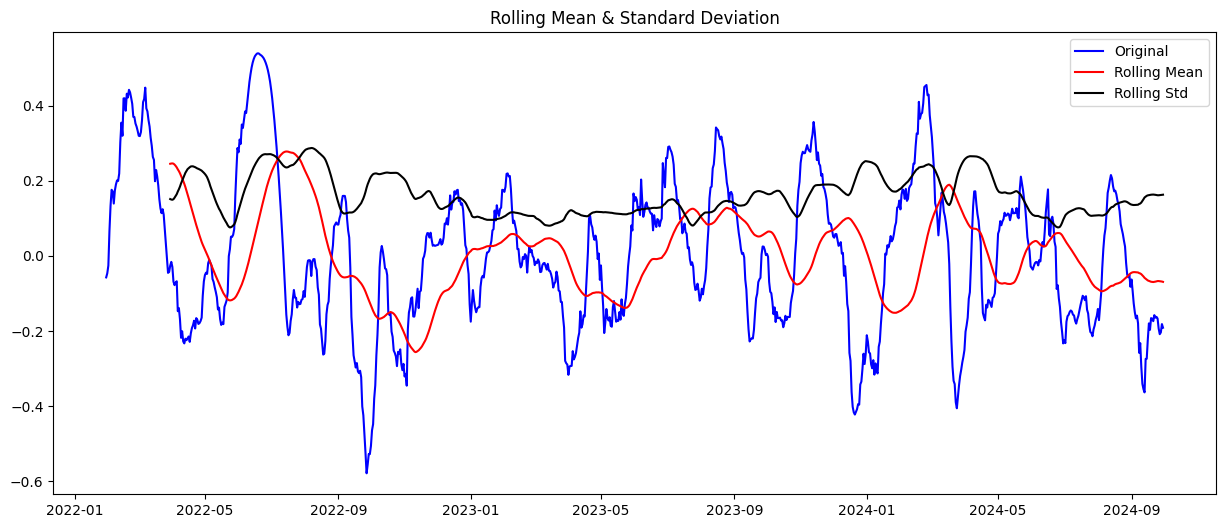

Results of Dickey-Fuller Test:
Test Statistic                  -5.543669
p-value                          0.000002
#Lags Used                      12.000000
Number of Observations Used    962.000000
Critical Value (1%)             -3.437166
Critical Value (5%)             -2.864549
Critical Value (10%)            -2.568372
dtype: float64


In [14]:
test_stationarity(ts_log_moving_avg_diff, 60)

####Exponentially Weighted Moving Average

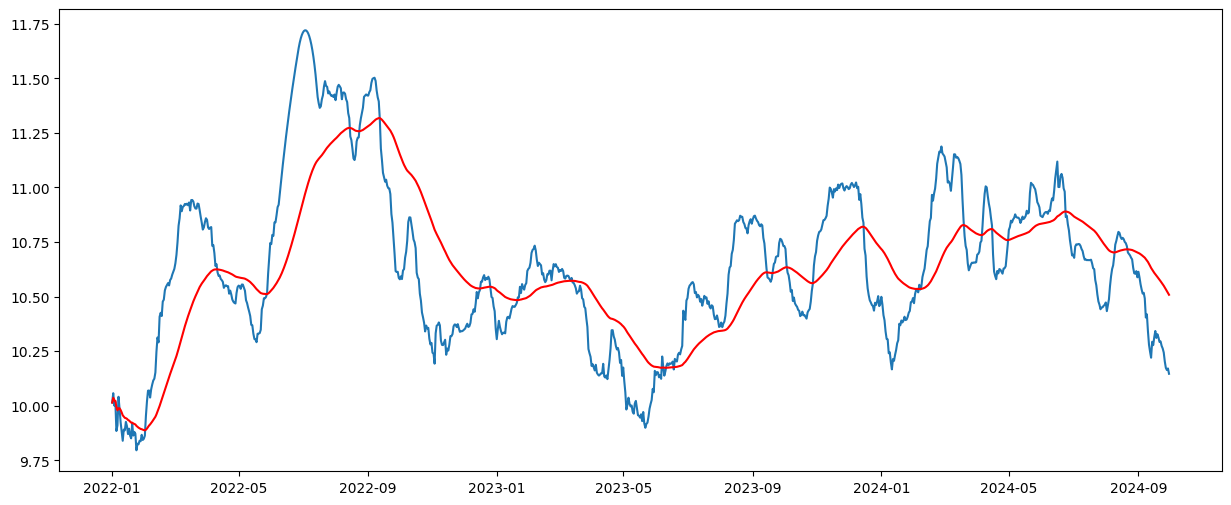

In [15]:
expwighted_avg = ts_log.ewm(halflife=30).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

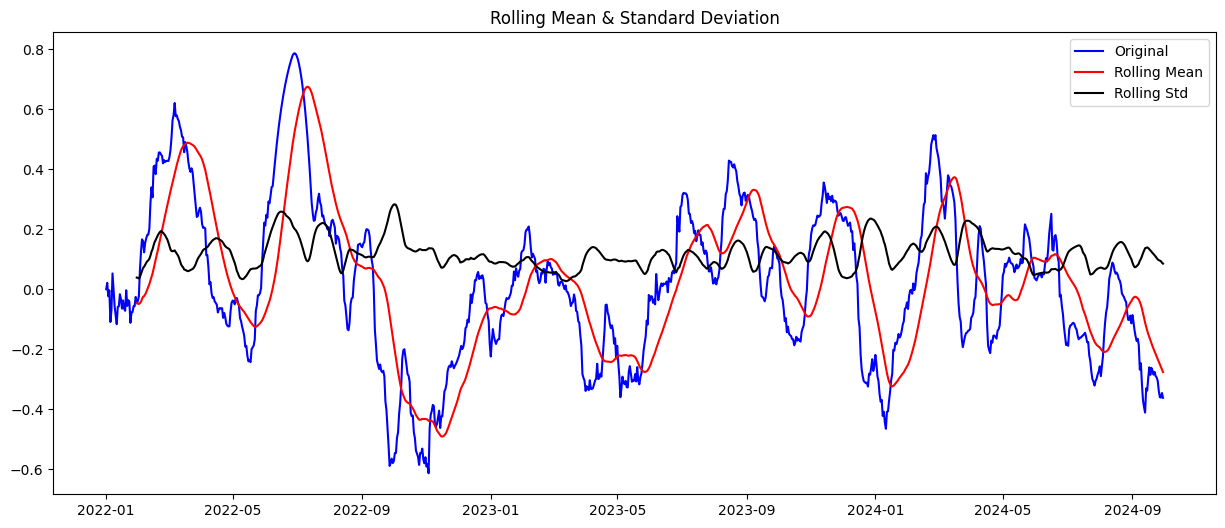

Results of Dickey-Fuller Test:
Test Statistic                  -3.773414
p-value                          0.003191
#Lags Used                      12.000000
Number of Observations Used    991.000000
Critical Value (1%)             -3.436966
Critical Value (5%)             -2.864461
Critical Value (10%)            -2.568325
dtype: float64


In [16]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff,30)

##Eliminating Trend and Seasonality

###Differencing

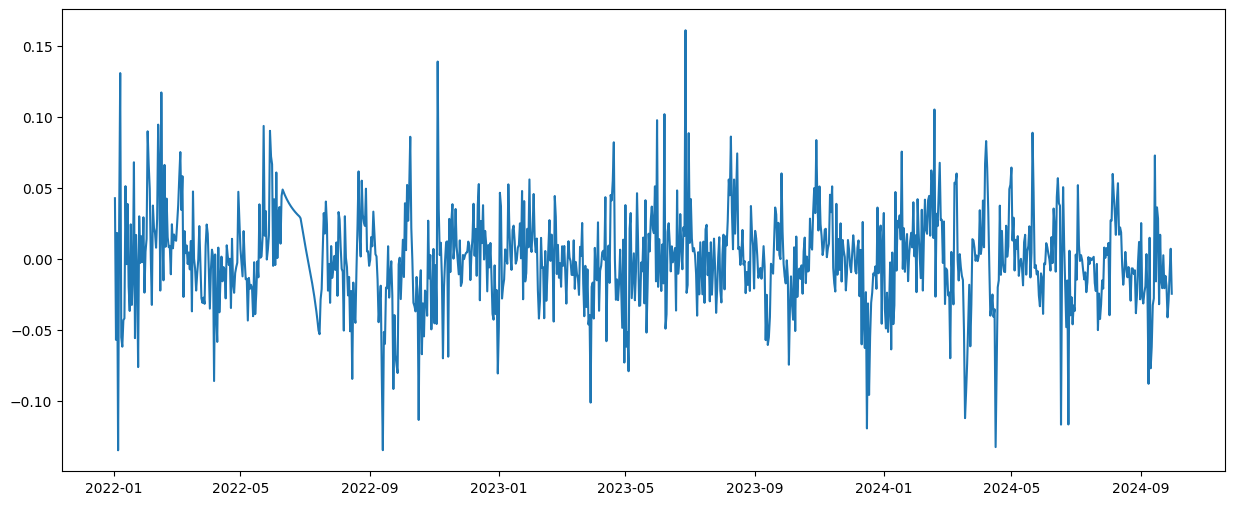

In [17]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

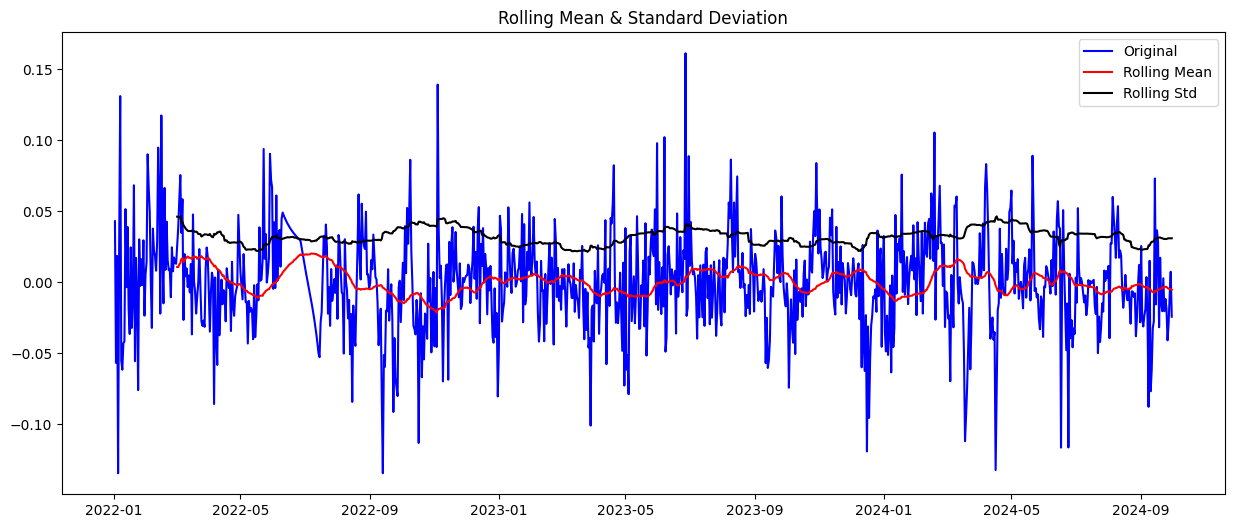

Results of Dickey-Fuller Test:
Test Statistic                -7.607849e+00
p-value                        2.296786e-11
#Lags Used                     1.100000e+01
Number of Observations Used    9.910000e+02
Critical Value (1%)           -3.436966e+00
Critical Value (5%)           -2.864461e+00
Critical Value (10%)          -2.568325e+00
dtype: float64


In [18]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff, 60)

###Decomposition

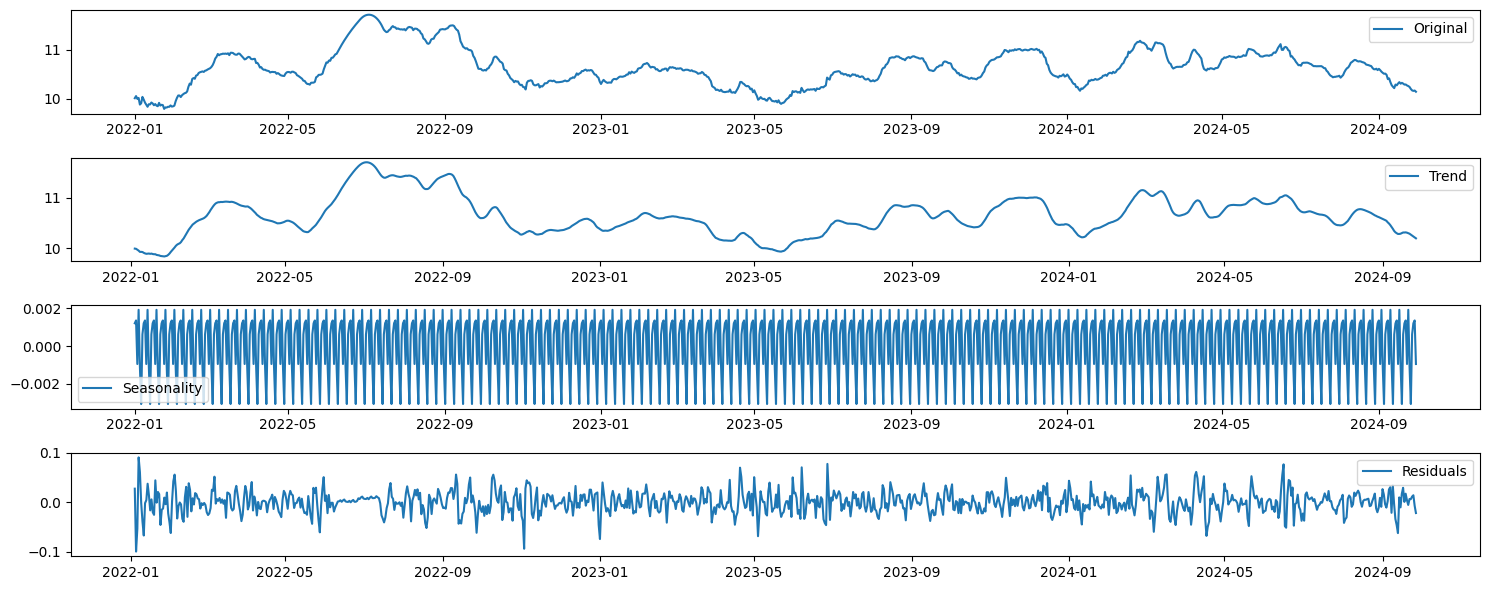

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

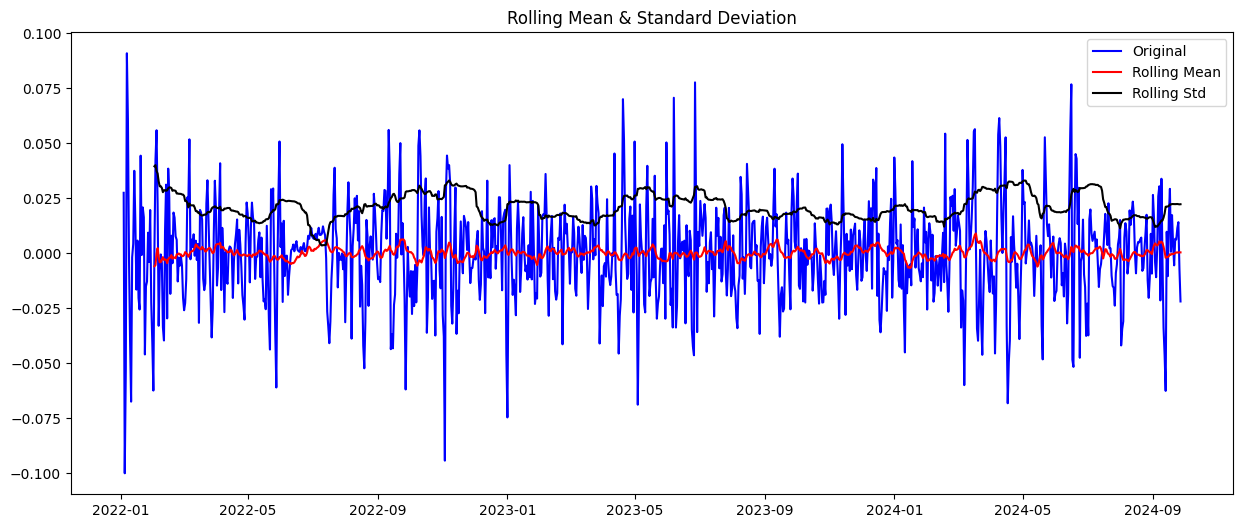

Results of Dickey-Fuller Test:
Test Statistic                -1.152519e+01
p-value                        3.951770e-21
#Lags Used                     1.700000e+01
Number of Observations Used    9.800000e+02
Critical Value (1%)           -3.437040e+00
Critical Value (5%)           -2.864494e+00
Critical Value (10%)          -2.568343e+00
dtype: float64


In [20]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose,30)

##Final Forecasting

### ACF & PACF Plot

In [21]:
from statsmodels.tsa.arima.model import ARIMA

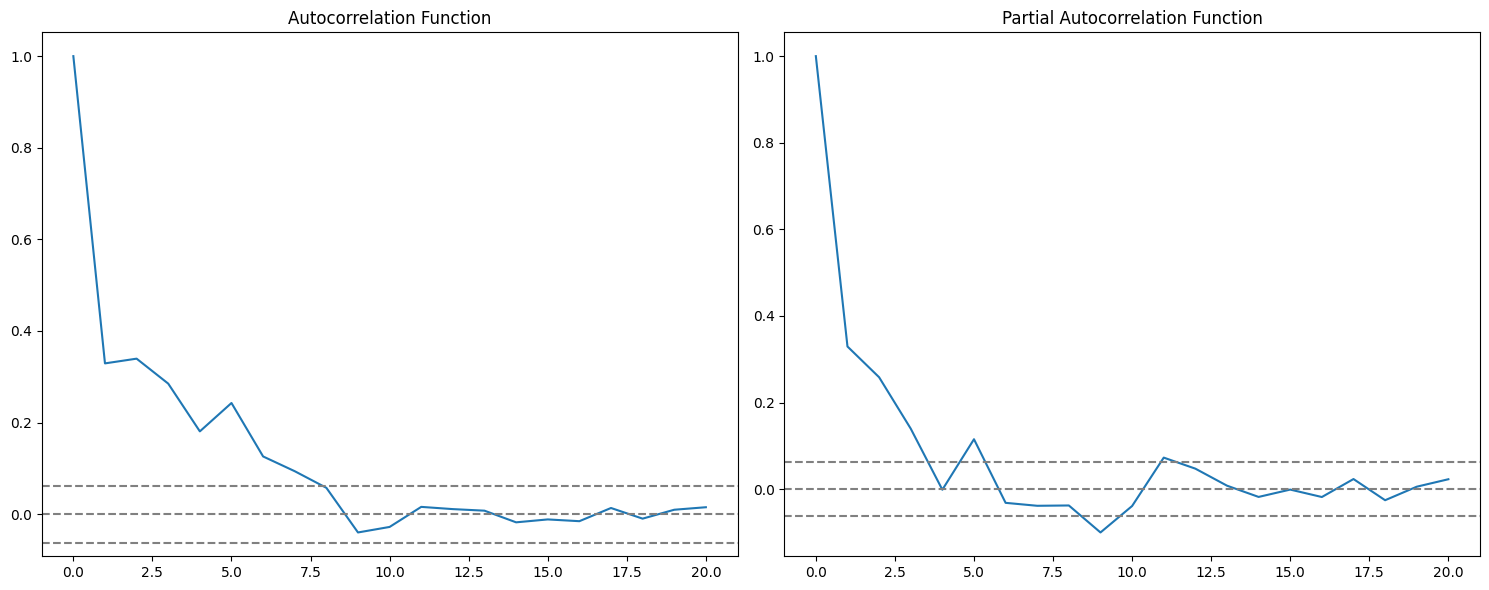

In [22]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### AR MODEL

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 0.8851')

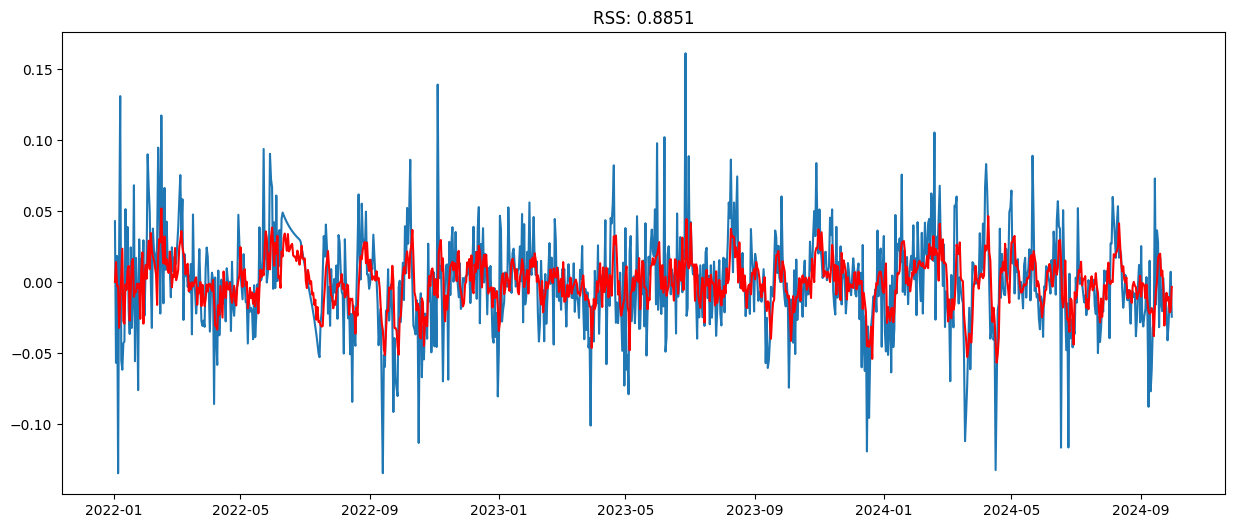

In [26]:
#MA model:
model = ARIMA(ts_log_diff, order=(50, 0, 0))  #ARIMA BARU vs ARIMA LAMA: arima lama input data nya adalah ts_log karena differentiating dilakukan oleh model. sedangkan arima baru data input nya harus
results_AR = model.fit(method='innovations_mle')
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

###MA Model

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 0.8897')

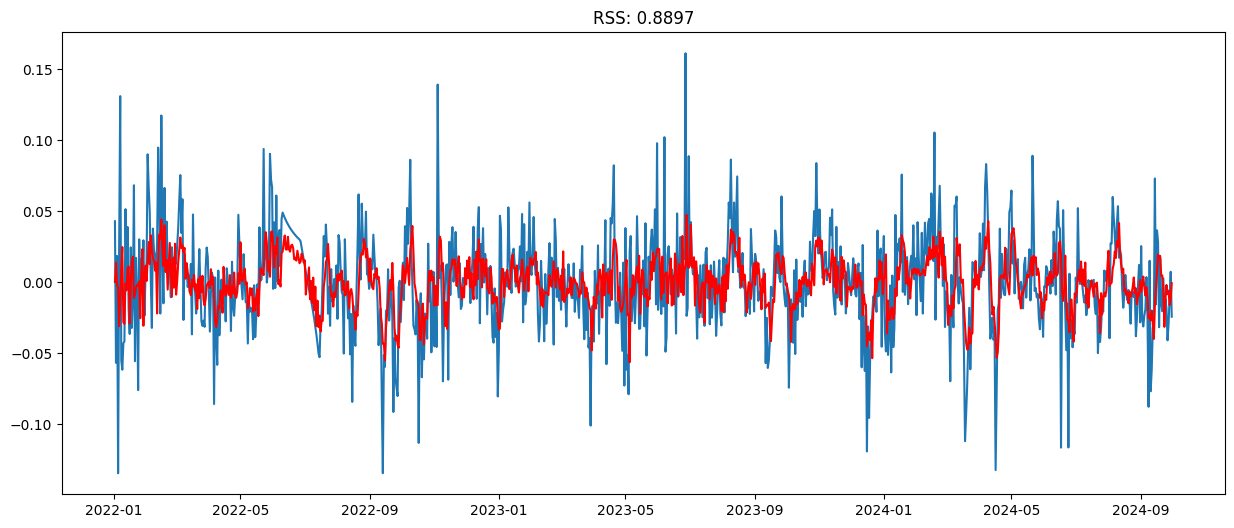

In [27]:
model = ARIMA(ts_log_diff, order=(0, 0, 50))  #ARIMA BARU vs ARIMA LAMA: arima lama input data nya adalah ts_log karena differentiating dilakukan oleh model. sedangkan arima baru data input nya harus
results_AR = model.fit(method='innovations_mle')
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

###ARIMA MODEL

In [ ]:
model = ARIMA(ts_log_diff, order=(50, 0, 50))  #ARIMA BARU vs ARIMA LAMA: arima lama input data nya adalah ts_log karena differentiating dilakukan oleh model. sedangkan arima baru data input nya harus
results_AR = model.fit(method='innovations_mle')
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Convert to original scale

In [ ]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
import ruptures as rpt

# Assume 'data' is your time series (a pandas Series)
algo = rpt.Pelt(model="l2").fit(data.values)
breakpoints = algo.predict(pen=10)  # Adjust penalty as needed
print("Structural breakpoints:", breakpoints)
